In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import fmin
import seaborn as sns
sns.set_context('talk')
sns.set_style('white')

RANDOM_SEED = 20090425

In [2]:
from io import StringIO

In [4]:
data_string = """
Drugs   Score
0   1.17    78.92
1   2.97    58.20
2   3.26    67.47
3   4.69    37.47
4   5.83    45.65
5   6.00    32.92
6   6.41    29.97
"""

In [6]:
lsd_and_math = pd.read_table(StringIO(data_string), sep="\s+", index_col=0)

In [7]:
lsd_and_math

,Drugs,Score
0,1.17,78.92
1,2.97,58.20
2,3.26,67.47
3,4.69,37.47
4,5.83,45.65
5,6.00,32.92
6,6.41,29.97


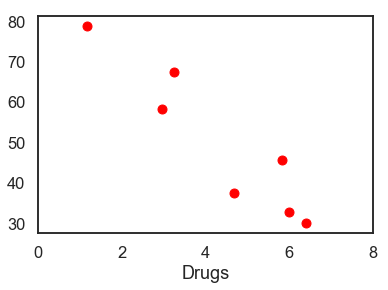

In [8]:
lsd_and_math.plot(x='Drugs', y='Score', style='ro', legend=False, xlim=(0,8));

In [10]:
sum_of_squares = lambda o, x,y: np.sum((y-o[0] - o[1]*x)**2)

In [11]:
sum_of_squares([0,1], lsd_and_math.Drugs, lsd_and_math.Score)

17158.260299999998

In [14]:
x,y = lsd_and_math.T.values
b0, b1 = fmin(sum_of_squares, [0,1], args=(x,y))
b0, b1

Optimization terminated successfully.
         Current function value: 253.874426
         Iterations: 100
         Function evaluations: 185


(89.11632466387383, -9.008055321144802)

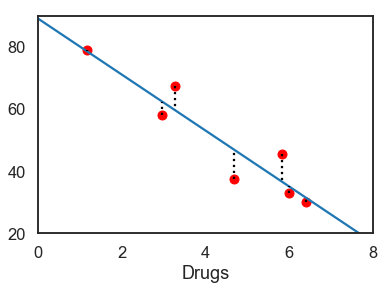

In [16]:
ax = lsd_and_math.plot(x='Drugs', y='Score', style='ro', legend=False, xlim=(0,8), ylim=(20,90))
ax.plot([0,10],[b0, b0+b1*10])
for xi, yi in zip(x,y):
    ax.plot([xi]*2, [yi, b0+b1*xi], 'k:')

In [18]:
sum_of_absval = lambda o, x, y: np.sum(np.abs(y-o[0]-o[1]*x))

Optimization terminated successfully.
         Current function value: 31.688624
         Iterations: 134
         Function evaluations: 258

intercept: 9e+01, slope: -9.3


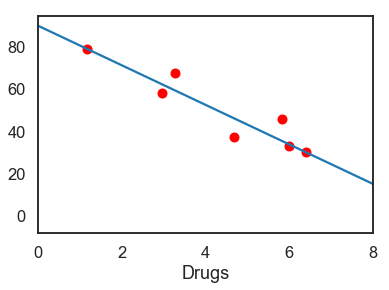

In [20]:
b0, b1 = fmin(sum_of_absval, [0,0], args=(x,y))
print('\nintercept: {0:.2}, slope: {1:.2}'.format(b0,b1))
ax = lsd_and_math.plot(x='Drugs', y='Score', style='ro', legend=False, xlim=(0,8))
ax.plot([0,10],[b0,b0+b1*10])

In [26]:
sum_squares_quad = lambda o, x, y: np.sum((y-o[0] - o[1]*x - o[2]*(x**2))**2)

Optimization terminated successfully.
         Current function value: 251.106901
         Iterations: 174
         Function evaluations: 315

intercept:9.2e+01, x: -1.1e+01, x2 0.24


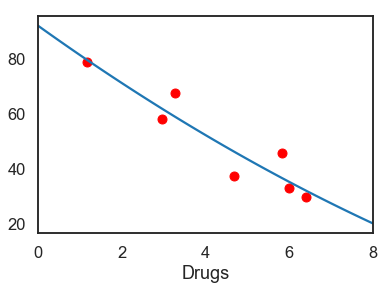

In [29]:
b0,b1,b2 = fmin(sum_squares_quad, [1,1,-1], args=(x,y))
print('\nintercept:{0:.2}, x: {1:.2}, x2 {2:.2}'.format(b0,b1,b2))
ax = lsd_and_math.plot(x='Drugs', y='Score', style='ro', legend=False, xlim=(0,8))
xvals = np.linspace(0,8,100)
ax.plot(xvals, b0+b1*xvals + b2*(xvals**2))


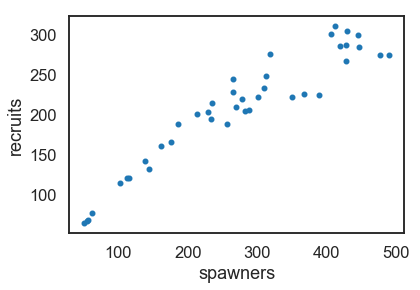

In [31]:
salmon = pd.read_table("salmon.dat", delim_whitespace=True, index_col=0)
salmon.plot.scatter(x='spawners', y='recruits')

C:\Users\Mathew Holden\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


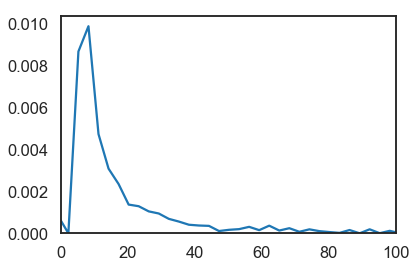

In [38]:
from pymc3 import HalfCauchy
ax = sns.kdeplot(HalfCauchy.dist(1).random(size=10000), gridsize=2000)
ax.set_xlim(0,100);

In [40]:
from pymc3 import Normal, Model

with Model() as drugs_model:
    intercept = Normal('intercept', 0, sd=100)
    slope = Normal('slope', 0, sd=100)
    o = HalfCauchy('o',1)

In [41]:
with drugs_model:
    u = intercept + slope*x
    score = Normal('score', u, sd=o, observed=y)

In [43]:
from pymc3 import sample
with drugs_model:
    drugs_sample = sample(1000, random_seed=RANDOM_SEED)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [o, slope, intercept]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:50<00:00, 58.82draws/s]
C:\Users\Mathew Holden\Anaconda3\lib\site-packages\mkl_fft\_numpy_fft.py:1044: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.rfftn_numpy(a, s, axes)
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


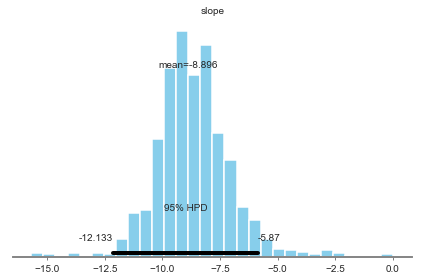

In [45]:
from pymc3 import plot_posterior
plot_posterior(drugs_sample[500:], varnames=['slope']);

In [46]:
from pymc3 import sample_ppc
with drugs_model:
    drugs_ppc = sample_ppc(drugs_sample, 100)

100%|██████████| 100/100 [00:00<00:00, 367.15it/s]


In [47]:
drugs_ppc['score'].shape

(100, 7)

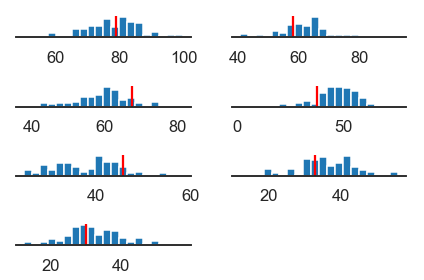

In [52]:
dig, axes = plt.subplots(4,2)
axes_flat = axes.flatten()

for ax, real_data, sim_data in zip(axes_flat[:-1], y, drugs_ppc['score'].T):
    ax.hist(sim_data, bins=20)
    ax.vlines(real_data, *ax.get_ylim(), colors='red')
    ax.set_yticklabels([])
    sns.despine(left=True)
    
axes_flat[-1].axis('off')
plt.tight_layout()

In [53]:
print("Mathew Holden")

Mathew Holden
